# Boundary detection

Data discontinuties are sharp change in a variable across a single or multiple borders. This can be used to detect outliers or models of inequality.

This is an analysis of median household income in San Diego

In [1]:
import contextily as ctx
import geopandas as gpd 
import rioxarray
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry
from pysal.lib import weights

In [2]:
san_diego_tracts = gpd.read_file("../data/sandiego_tracts.gpkg")

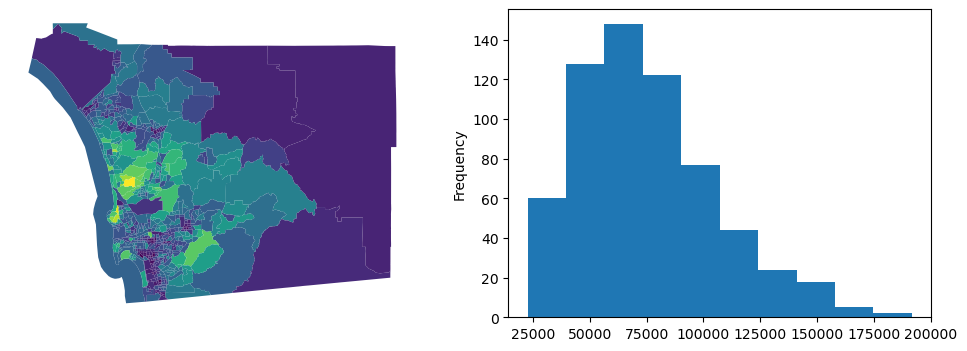

In [3]:
f, ax = plt.subplots(1, 2, figsize=(12,4))
san_diego_tracts.plot("median_hh_income", ax=ax[0])
ax[0].set_axis_off() 
san_diego_tracts["median_hh_income"].plot.hist(ax=ax[1]);

>Sharp differences exist between neighboring areas. Examine the _distribution of differences_ in neighboring areas with an adjacency list

In [4]:
w_rook = weights.contiguity.Rook.from_dataframe(san_diego_tracts, use_index=False)
adjlist = w_rook.to_adjlist(drop_islands=True)

In [5]:
adjlist.head()

,focal,neighbor,weight
0,0,1,1.0
1,0,4,1.0
2,0,27,1.0
3,0,383,1.0
4,0,385,1.0


>Connect the table representing spatial structure with the information on median household income.

In [7]:
adjlist_income = adjlist.merge(
    san_diego_tracts[["median_hh_income"]], 
    how='left', 
    left_on='focal', 
    right_index=True
).merge(
    san_diego_tracts[["median_hh_income"]], 
    how='left', 
    left_on='neighbor', 
    right_index=True, 
    suffixes=("_focal", "_neighbor")
)
adjlist_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   focal                      3440 non-null   int64  
 1   neighbor                   3440 non-null   int64  
 2   weight                     3440 non-null   float64
 3   median_hh_income_focal     3440 non-null   float64
 4   median_hh_income_neighbor  3440 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 134.5 KB


>Calculate income difference between adjacent tracts

In [8]:
adjlist_income["diff"] = (
    adjlist_income.median_hh_income_focal - adjlist_income.median_hh_income_neighbor
)

>Compare this distribution is distinct from the distribution of wealth differences in non-neighboring tracts. This can suggest the extent to which income follows a spatial pattern. cf. Spatial Gini

>Compute all-pairs differences with `numpy.subtract`

In [9]:
all_pairs = np.subtract.outer(
    san_diego_tracts.median_hh_income.values, 
    san_diego_tracts.median_hh_income.values
)

In [10]:
all_pairs.shape

(628, 628)

>all_pairs is NxN with the difference of all combinations of input vectors

>To filter out neighbors, since the weights matrix is binary, can subtract all_pairs from an NxN matrix of 1s

In [11]:
complement_wr = 1 - w_rook.sparse.toarray()

In [12]:
non_neighboring_diffs = (complement_wr * all_pairs).flatten()

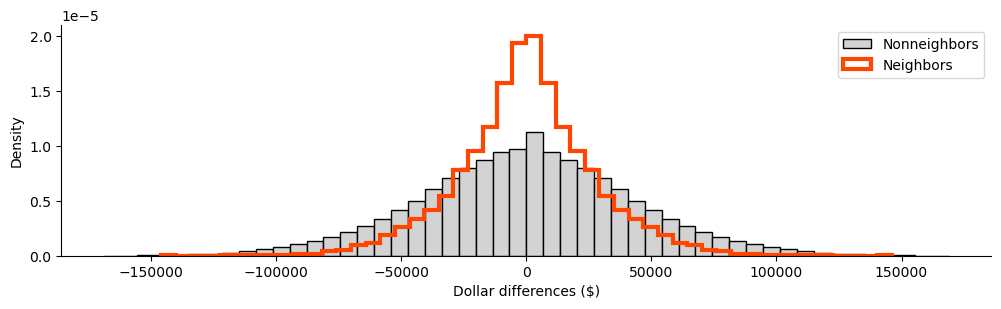

In [15]:
f = plt.figure(figsize=(12,3))
plt.hist(
    non_neighboring_diffs, 
    color='lightgrey', 
    ec='k', 
    density=True, 
    bins=50, 
    label='Nonneighbors'
)
plt.hist(
    adjlist_income["diff"], 
    color='salmon', 
    ec='orangered', 
    lw=3, 
    density=True, 
    histtype='step', 
    bins=50, 
    label='Neighbors'
)
sns.despine() 
plt.ylabel("Density")
plt.xlabel("Dollar differences ($)")
plt.legend();

>Find most extreme differences

In [16]:
extremes = adjlist_income.sort_values("diff", ascending=False).head()
extremes

,focal,neighbor,weight,median_hh_income_focal,median_hh_income_neighbor,diff
2606,473,163,1.0,183929.0,37863.0,146066.0
2605,473,157,1.0,183929.0,64688.0,119241.0
1890,343,510,1.0,151797.0,38125.0,113672.0
2607,473,238,1.0,183929.0,74485.0,109444.0
51,8,89,1.0,169821.0,66563.0,103258.0


>Use map randomization to determine the significance of the differences. Shuffle the values across the map and compute new diffs, which will represent difference between random incomes.

In [17]:
n_simulations = 200
simulated_diffs = np.empty((len(adjlist), n_simulations))
for i in range(n_simulations): 
    median_hh_focal = adjlist_income.median_hh_income_focal.values 
    random_income = (san_diego_tracts.median_hh_income
                    .sample(frac=1, replace=False)
                    .reset_index())
    adjlist_random_income = adjlist.merge(
        random_income, left_on="focal", right_index=True
    ).merge(
        random_income, 
        left_on='neighbor', 
        right_index=True, 
        suffixes=("_focal", "_neighbor")
    )
    simulated_diffs[:, i] = (
        adjlist_random_income.median_hh_income_focal - 
        adjlist_random_income.median_hh_income_neighbor
    )

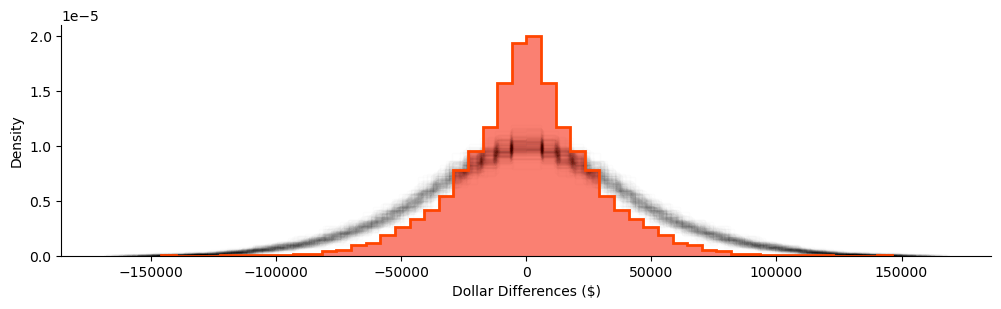

In [18]:
# Set up figure
f = plt.figure(figsize=(12, 3))
# Build background histogram for observed differences
plt.hist(
    adjlist_income["diff"],
    color="salmon",
    bins=50,
    density=True,
    alpha=1,
    linewidth=4,
)
# Plot simulated, random differences
[
    plt.hist(
        simulation,
        histtype="step",
        color="k",
        alpha=0.01,
        linewidth=1,
        bins=50,
        density=True,
    )
    for simulation in simulated_diffs.T
]
# Build histogram borderline for observed differences
plt.hist(
    adjlist_income["diff"],
    histtype="step",
    edgecolor="orangered",
    bins=50,
    density=True,
    linewidth=2,
)
# Style figure
sns.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.show()

In [19]:
n_simulations = 2000
simulated_diffs = np.empty((len(adjlist), n_simulations))
for i in range(n_simulations): 
    median_hh_focal = adjlist_income.median_hh_income_focal.values 
    random_income = (san_diego_tracts.median_hh_income
                    .sample(frac=1, replace=False)
                    .reset_index())
    adjlist_random_income = adjlist.merge(
        random_income, left_on="focal", right_index=True
    ).merge(
        random_income, 
        left_on='neighbor', 
        right_index=True, 
        suffixes=("_focal", "_neighbor")
    )
    simulated_diffs[:, i] = (
        adjlist_random_income.median_hh_income_focal - 
        adjlist_random_income.median_hh_income_neighbor
    )

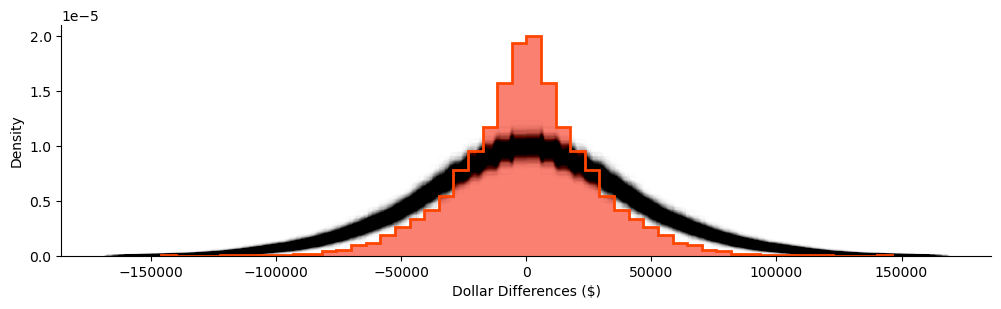

In [26]:
# Set up figure
f = plt.figure(figsize=(12, 3))
# Build background histogram for observed differences
plt.hist(
    adjlist_income["diff"],
    color="salmon",
    bins=50,
    density=True,
    alpha=1,
    linewidth=4,
)
# Plot simulated, random differences
[
    plt.hist(
        simulation,
        histtype="step",
        color="k",
        alpha=0.01,
        linewidth=1,
        bins=50,
        density=True,
    )
    for simulation in simulated_diffs.T
]
# Build histogram borderline for observed differences
plt.hist(
    adjlist_income["diff"],
    histtype="step",
    edgecolor="orangered",
    bins=50,
    density=True,
    linewidth=2,
)
# Style figure
sns.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.show()

In [21]:
simulated_diffs.flatten().shape

(6880000,)

>Create vector of sim diffs

In [22]:
pooled_diffs = simulated_diffs.flatten() 
lower, median, upper = np.percentile(
    pooled_diffs, q=(0.5, 50, 99.5)
)
outside = (adjlist_income['diff'] < lower) | (adjlist_income['diff'] > upper)

In [23]:
adjlist_income[outside]

,focal,neighbor,weight,median_hh_income_focal,median_hh_income_neighbor,diff
888,157,473,1.0,64688.0,183929.0,-119241.0
916,163,473,1.0,37863.0,183929.0,-146066.0
2605,473,157,1.0,183929.0,64688.0,119241.0
2606,473,163,1.0,183929.0,37863.0,146066.0


473 is likely to be an extreme outlier.

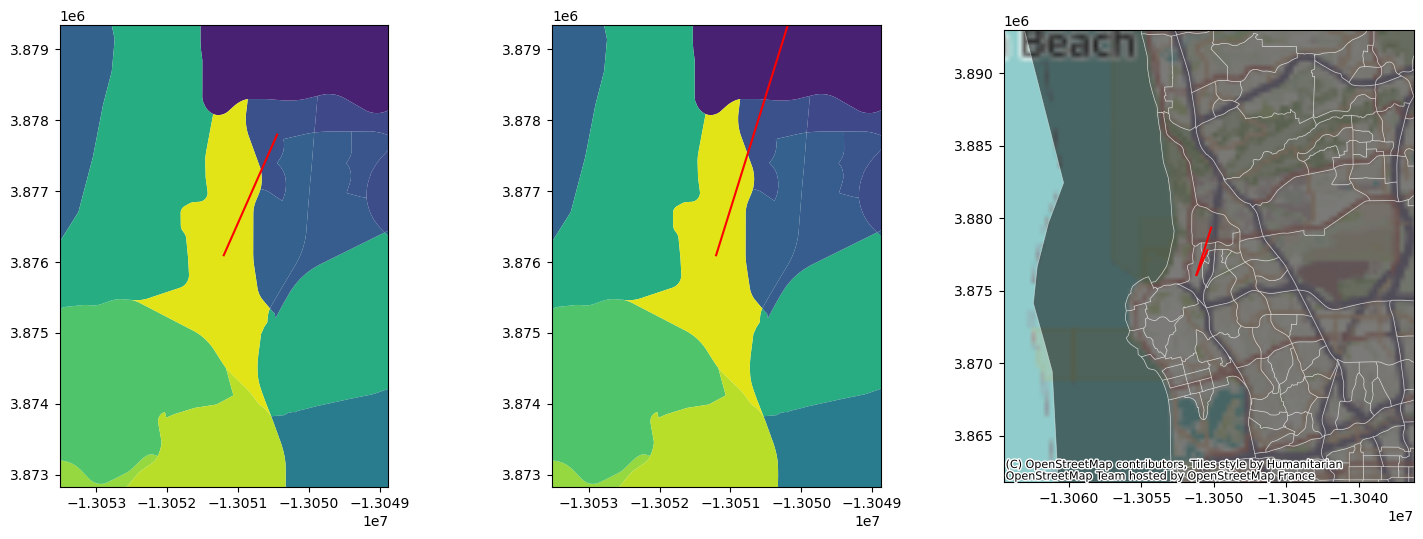

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot tracts

[san_diego_tracts.plot("median_hh_income", ax=ax) for ax in (ax1, ax2)]

# Zoom 1
first_focus = san_diego_tracts.iloc[[473, 157]]
ax1.plot(
    first_focus.centroid.x, first_focus.centroid.y, color="red"
)
west, east, south, north = first_focus.buffer(1000).total_bounds
ax1.axis([west, south, east, north])

# Zoom 2
second_focus = san_diego_tracts.iloc[[473, 163]]
ax2.plot(
    second_focus.centroid.x, second_focus.centroid.y, color="red"
)
ax2.axis([west, south, east, north])

# Context
san_diego_tracts.plot(
    facecolor="k", edgecolor="w", linewidth=0.5, alpha=0.5, ax=ax3
)
ctx.add_basemap(ax3, crs=san_diego_tracts.crs)
area_of_focus = (
    pd.concat((first_focus, second_focus))
    .buffer(12000)
    .total_bounds
)
ax3.plot(
    first_focus.centroid.x, first_focus.centroid.y, color="red"
)
ax3.plot(
    second_focus.centroid.x, second_focus.centroid.y, color="red"
)
west, east, south, north = area_of_focus
ax3.axis([west, south, east, north])

[ax.set_axis_off for ax in (ax1, ax2, ax3)]
plt.show()
